In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix,accuracy_score,jaccard_score,f1_score,log_loss,classification_report
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from joblib import dump, load
dest = '/content/drive/MyDrive/Python/Chicago-Crime/'
BaseDat = pd.read_csv(dest + 'Chicago_Crime_Final_Data.csv')

In [ ]:
#- i will keep only the most frequent types for prediction -#
KeepList = ['BATTERY','THEFT','CRIMINAL DAMAGE','ASSAULT','DECEPTIVE PRACTICE',
            'OTHER OFFENSE','MOTOR VEHICLE THEFT','WEAPONS VIOLATION','ROBBERY','BURGLARY']
BaseDat = BaseDat[BaseDat['primary_type'].isin(KeepList)]
BaseDat['Location_Desc'] = BaseDat.location_description.astype("category").cat.codes
BaseDat = BaseDat.drop(columns=['location_description','Date'])
BaseDat.primary_type = BaseDat.primary_type.str.replace(' ', '_')
BaseDat.head(3) 

## Descriptive stat

In [ ]:
print(BaseDat['Location_Desc'].value_counts())
print(BaseDat['primary_type'].value_counts())
pd.DataFrame(BaseDat.groupby('primary_type').mean()).to_excel(dest + 'Features-Mean-by-Type.xlsx')
BaseDat = pd.concat([BaseDat,pd.get_dummies(BaseDat['primary_type'])], axis = 1)
pd.DataFrame(BaseDat.corr()).to_excel(dest + 'Corr_mat.xlsx')

In [ ]:
#- logistic regression for learning the data -#
# choose for y the type of crime you want to be as dep. var
DropList = ['primary_type', 'ASSAULT','BATTERY', 'BURGLARY', 'CRIMINAL_DAMAGE', 'DECEPTIVE_PRACTICE',
       'MOTOR_VEHICLE_THEFT', 'OTHER_OFFENSE', 'ROBBERY', 'THEFT','WEAPONS_VIOLATION']
Dep = BaseDat.loc[:, BaseDat.columns == 'ASSAULT']
Ind = BaseDat.drop(DropList,axis=1)
print(Ind.columns)
log_reg = sm.Logit(Dep, Ind).fit()
print(log_reg.summary())
print(np.exp(log_reg.params))

### Standartization and spliting

In [ ]:
y = BaseDat.loc[:, BaseDat.columns == 'primary_type']
X = BaseDat.drop(DropList,axis=1)
#- convert to arrays -#
X = np.asarray(X)
y = np.asarray(y)
#- standardizing the features and spliting for train/test -#
X = preprocessing.StandardScaler().fit(X).transform(X)
print(X.shape)
#- split -#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Multi-Class Classification Scikit-Learn Models:

## **note:** this step is taking more than a hour of run

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
# fit the models
MLPC_classifier = MLPClassifier().fit(X_train, y_train)
RFC_classifier = RandomForestClassifier().fit(X_train, y_train)
KNN_classifier = KNeighborsClassifier().fit(X_train, y_train)
LOG_classifier = LogisticRegressionCV().fit(X_train, y_train)
SVM_classifier = SVC(kernel='linear',C=1).fit(X_train, y_train)
# save the fitted models for future use
dump(MLPC_classifier, str(dest + 'MLPC.joblib'))
dump(RFC_classifier, str(dest + 'RFC.joblib'))
dump(KNN_classifier, str(dest + 'KNN.joblib'))
dump(LOG_classifier, str(dest + 'LOG.joblib'))
dump(SVM_classifier, str(dest + 'SVM.joblib'))
# perdict the output
MLPC_Pred = MLPC_classifier.predict(X_test)
RFC_Pred = RFC_classifier.predict(X_test)
KNN_Pred = KNN_classifier.predict(X_test)
LOG_Pred = LOG_classifier.predict(X_test)
SVM_Pred = SVM_classifier.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:641: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  intercept_grads,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr

In [ ]:
# accuracy comparison
Compare_Table = pd.DataFrame(columns=['Model','Accuracy'])
PredList = [MLPC_Pred,RFC_Pred,KNN_Pred,LOG_Pred,SVM_Pred]
ModelsList = ['MLPC','RFC','KNN','LOG','SVM']
for k in range(0,5):
  Accu = accuracy_score(y_test, PredList[k])
  Compare_Table = Compare_Table.append({'Model': ModelsList[k], 'Accuracy': Accu}, ignore_index=True)

Compare_Table = Compare_Table.sort_values(by='Accuracy', ascending=False)
print(Compare_Table)

  Model  Accuracy
0  MLPC  0.290829
1   RFC  0.271072
3   LOG  0.248267
4   SVM  0.235614
2   KNN  0.195008


## Confusion Matrix for the best model

[['ASSAULT' 3788]
 ['BATTERY' 7520]
 ['BURGLARY' 1205]
 ['CRIMINAL_DAMAGE' 4619]
 ['DECEPTIVE_PRACTICE' 2833]
 ['MOTOR_VEHICLE_THEFT' 1923]
 ['OTHER_OFFENSE' 2563]
 ['ROBBERY' 1432]
 ['THEFT' 7204]
 ['WEAPONS_VIOLATION' 1686]]


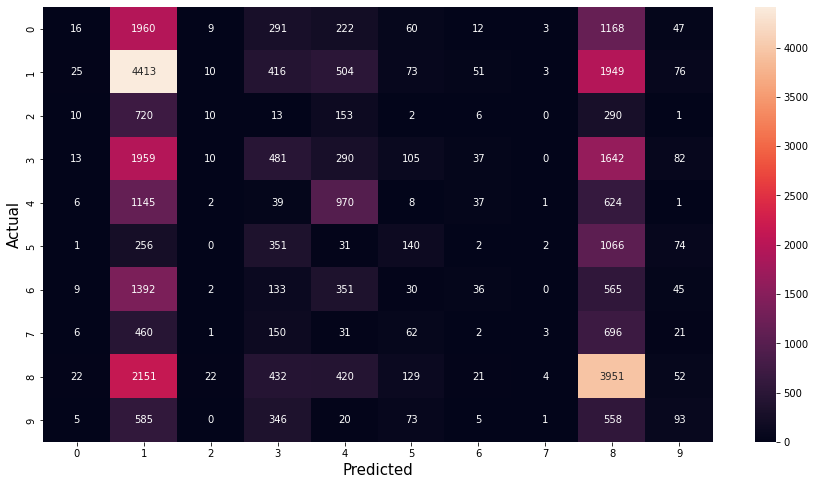

In [ ]:
print(np.array(np.unique(y_test, return_counts=True)).T)
fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(confusion_matrix(y_test, MLPC_Pred), annot=True, fmt="d")
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Actual', fontsize = 15)
plt.show()

## let's try without the climate data

In [ ]:
BaseDat.columns

Index(['primary_type', 'beat', 'ward', 'Hour', 'HubDist', 'PRCP', 'SNOW',
       'SNWD', 'TMAX', 'TMIN', 'WDF2', 'WSF2', 'WT01', 'WT02', 'WT03', 'WT04',
       'WT06', 'WT08', 'WT09', 'DayOfWeek', 'Month', 'Dholiday',
       'Location_Desc', 'ASSAULT', 'BATTERY', 'BURGLARY', 'CRIMINAL_DAMAGE',
       'DECEPTIVE_PRACTICE', 'MOTOR_VEHICLE_THEFT', 'OTHER_OFFENSE', 'ROBBERY',
       'THEFT', 'WEAPONS_VIOLATION'],
      dtype='object')

In [ ]:
from sklearn.neural_network import MLPClassifier
ClimateVarList = ['PRCP', 'SNOW','SNWD', 'TMAX', 'TMIN', 'WDF2', 'WSF2', 'WT01', 'WT02', 'WT03', 'WT04','WT06', 'WT08', 'WT09']
y = BaseDat.loc[:, BaseDat.columns == 'primary_type']
X = BaseDat.drop(DropList,axis=1)
X = X.drop(ClimateVarList,axis=1)
print(X.columns)
#- convert to arrays -#
X = np.asarray(X)
y = np.asarray(y)
#- standardizing the features and spliting for train/test -#
X = preprocessing.StandardScaler().fit(X).transform(X)
print(X.shape)
#- split -#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# fit the MLPC model
MLPC_No_Clim = MLPClassifier().fit(X_train, y_train)
dump(MLPC_No_Clim, str(dest + 'MLPC_No_Clim.joblib'))
# perdict the output
MLPC_No_Clim_Pred = MLPC_No_Clim.predict(X_test)
Accu = accuracy_score(y_test,MLPC_No_Clim_Pred)
print('Accuracy without Climate Features:', Accu)

Index(['beat', 'ward', 'Hour', 'HubDist', 'DayOfWeek', 'Month', 'Dholiday',
       'Location_Desc'],
      dtype='object')
(173865, 8)
(139092, 8) (34773, 8) (139092, 1) (34773, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:641: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  intercept_grads,


Accuracy without Climate Features: 0.29511402524947516
